# Drift Simulator

## User Specifications

In [1]:
### User can change these variables (unless they begin with an underscore) ###

drift_model = 'turnbull'  # must be 'turnbull' or 'wagner'
ocean_model = 'ecmwf'  # must be 'ecmwf'
atm_model = 'ecmwf'  # must be 'ecmwf'


iip_season = 2015  # must be 2015 (more to come later)

# Uncomment only one of the following
_method = 'index'; iip_indices = range(3284, 3286)  # iip_indices must be int or range
#_method = 'ID'; iip_ID = 20668  # iip_ID must be int

## Imports

In [2]:
from datetime import timedelta
import numpy as np

In [3]:
if drift_model == 'turnbull':
    from icedef.turnbull import drift
elif drift_model == 'wagner':
    from iceberg.wagner import drift
else:
    print('drift model specified is invalid')
    
from icedef import iceberg, metocean, plot

## Iceberg Data

In [4]:
if _method == 'index':
    identifier = iip_indices
elif _method == 'ID':
    identifier = iip_ID
else:
    print("Invalid method specified. Please change _method to either 'index' or 'ID'")

In [5]:
iip_berg_df, iip_berg = iceberg.get_iip_iceberg(2015, _method, identifier)

/home/evankielley/IceDEF/icedef/iceberg.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.hour, unit='h')
/home/evankielley/IceDEF/icedef/iceberg.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.minute, unit='m')


In [6]:
iip_berg_df

,index,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,3284,2015,20668,6/17/2015,1043,48.16,-50.16,R/V,LG,GEN,GMRS,2015-06-17 10:43:00
1,3285,2015,20668,6/18/2015,1251,48.17,-49.91,VIS,LG,TAB,GTJZ,2015-06-18 12:51:00


In [7]:
mod_berg = iceberg.clone_iceberg_state(iip_berg)

## Metocean Data

In [8]:
ocean_data = metocean.ECMWF_Ocean(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

ocean_data.filenames

['20150617.nc', '20150618.nc']

In [9]:
atm_data = metocean.ECMWF_Atm(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

atm_data.filenames

['sub20150617.nc', 'sub20150618.nc']

## Timesteps

In [15]:
t_step_hours = 0.5

t0 = iip_berg.history['T'][0]
tf = iip_berg.history['T'][-1]
t_delta = tf - t0
t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
t_step = timedelta(hours = t_step_hours)
dt = t_step_hours*3600  # timestep in seconds
t_all = []

for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
    new_date = t0 + timedelta(hours=i)
    t_all.append(new_date)

## Drifting

In [18]:
#%%prun -T profiled_drift.txt
earth_radius = 6378*1e3  # radius of Earth  (m)


# Buffer number for bounding spatial box
drift_xmin = max(min(ocean_data.lons), min(atm_data.lons))
drift_xmax = min(max(ocean_data.lons), max(atm_data.lons))
drift_ymin = max(min(ocean_data.lats), min(atm_data.lats))
drift_ymax = min(max(ocean_data.lats), max(atm_data.lats))

mod_berg_list = []

tsteplist = [t_step_hours]

for t_step_hours in tsteplist:

    mod_berg = iceberg.clone_iceberg_state(iip_berg)
    
    #t_step_hours = 0.1
    t0 = iip_berg.history['T'][0]
    tf = iip_berg.history['T'][-1]
    t_delta = tf - t0
    t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
    t_step = timedelta(hours = t_step_hours)
    dt = t_step_hours*3600  # timestep in seconds
    t_all = []

    for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
        new_date = t0 + timedelta(hours=i)
        t_all.append(new_date)

    for t in t_all:

        mod_berg.T = t

        if drift_model == 'turnbull':

            ax, ay = drift(mod_berg, ocean_data, atm_data) 

            mod_berg.Vx += dt*ax  
            mod_berg.Vy += dt*ay

        elif drift_model == 'wagner':

            mod_berg.Vx, mod_berg.Vy = drift(mod_berg, ocean_data, atm_data) 


        # Iceberg position (note the conversion from meters back to degrees)
        y_ = mod_berg.Y
        mod_berg.Y += dt*mod_berg.Vy*(180/(np.pi*earth_radius))  # y-component of iceberg position (degrees latitude)
        mod_berg.X += dt*mod_berg.Vx/(np.cos((((y_ + mod_berg.Y)/2)*np.pi)/180))*(180/(np.pi*earth_radius))  # x-component of iceberg position (degrees longitude)

        if not drift_xmin < mod_berg.X < drift_xmax:
            print('Iceberg out-of-bounds')
            break

        elif mod_berg.X < drift_xmin: 
            print('Iceberg out-of-bounds')
            break

        elif mod_berg.Y > drift_ymax:
            print('Iceberg out-of-bounds')
            break

        elif mod_berg.Y < drift_ymin:
            print('Iceberg out-of-bounds')
            break


        else:
            mod_berg.history['T'].append(mod_berg.T)
            mod_berg.history['X'].append(mod_berg.X)
            mod_berg.history['Y'].append(mod_berg.Y)
            mod_berg.history['Vx'].append(mod_berg.Vx)
            mod_berg.history['Vy'].append(mod_berg.Vy)

    print("Final time: {}".format(t)) 
    
    mod_berg_list.append(mod_berg)

Final time: 2015-06-18 13:13:00


## Plotting

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


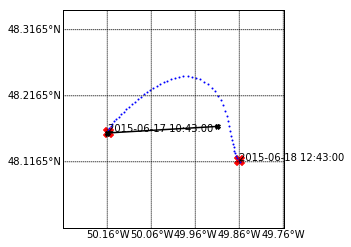

In [17]:
for mod_berg in mod_berg_list:
    plot.plot_drift_track_test_case(iip_berg, mod_berg)